In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize Spark session
spark = SparkSession.builder.appName("DiabetesPrediction").getOrCreate()

# Load dataset
data = spark.read.csv("file:/home/talentum/shared/binary_diabetes_data.csv", header=True, inferSchema=True)
df=data

In [2]:
df.head()

Row(Diabetes_012=0, HighBP=1.0, HighChol=1.0, CholCheck=1.0, BMI=40.0, Smoker=1.0, Stroke=0.0, HeartDiseaseorAttack=0.0, PhysActivity=0.0, Fruits=0.0, Veggies=1.0, HvyAlcoholConsump=0.0, AnyHealthcare=1.0, NoDocbcCost=0.0, GenHlth=5.0, MentHlth=18.0, PhysHlth=15.0, DiffWalk=1.0, Sex=0.0, Age=9.0, Education=4.0, Income=3.0)

In [3]:
df.limit(5).toPandas()  # Converts first 5 rows to Pandas DataFrame (if needed)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
df.printSchema()  # Shows column names, data types, and nullable info

root
 |-- Diabetes_012: integer (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- HvyAlcoholConsump: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Education: double (nullable = true)
 |-- Income: double (nullable = true)



In [5]:
print((df.count(), len(df.columns)))  # Prints (num_rows, num_columns)

(253680, 22)


In [6]:
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|Diabetes_012|HighBP|HighChol|CholCheck|BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|
+------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+
|           0|     0|       0|        0|  0|     0|     0|                   0|           0|     0|      0|                0|            0|          0|      0|       0|       0|       0|  0|  0|        0|     0|
+------------+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-

In [7]:
from pyspark.sql.functions import count

# Count duplicate rows
duplicate_count = df.count() - df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")

# Drop duplicates
df = df.dropDuplicates()

# Print new shape after dropping duplicates
print(f"Rows: {df.count()}, Columns: {len(df.columns)}")

Number of duplicate rows: 23968
Rows: 229712, Columns: 22


In [8]:
for col in df.columns:
    value_counts = df.groupBy(col).count().toPandas()
    print(f"{col} : \n{value_counts}\n")

Diabetes_012 : 
   Diabetes_012   count
0             1   39657
1             0  190055

HighBP : 
   HighBP   count
0     0.0  125336
1     1.0  104376

HighChol : 
   HighChol   count
0       0.0  128249
1       1.0  101463

CholCheck : 
   CholCheck   count
0        0.0    9298
1        1.0  220414

BMI : 
     BMI  count
0   67.0     15
1   70.0     15
2   69.0      9
3   88.0      2
4   49.0    416
..   ...    ...
79  54.0    113
80  43.0   1499
81  76.0      3
82  90.0      1
83  91.0      1

[84 rows x 2 columns]

Smoker : 
   Smoker   count
0     0.0  122738
1     1.0  106974

Stroke : 
   Stroke   count
0     0.0  219429
1     1.0   10283

HeartDiseaseorAttack : 
   HeartDiseaseorAttack   count
0                   0.0  206002
1                   1.0   23710

PhysActivity : 
   PhysActivity   count
0           0.0   61268
1           1.0  168444

Fruits : 
   Fruits   count
0     0.0   88920
1     1.0  140792

Veggies : 
   Veggies   count
0      0.0   47146
1      1.0  182566


Python 2.7.17
/usr/bin/python


In [14]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install matplotlib


  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 1.7MB 527kB/s ta 0:00:011
Defaulting to user installation because normal site-packages is not writeable


In [15]:
!pip show matplotlib




Name: matplotlib
Version: 3.3.3
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /home/talentum/.local/lib/python3.6/site-packages
Requires: cycler, kiwisolver, numpy, pillow, pyparsing, python-dateutil
Required-by: 


In [16]:
!pip install --upgrade matplotlib


Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.3.4-cp36-cp36m-manylinux1_x86_64.whl (11.5 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.3
    Uninstalling matplotlib-3.3.3:
      Successfully uninstalled matplotlib-3.3.3


In [17]:
!pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 1.2 MB/s            


In [18]:
!pip install --upgrade seaborn


Defaulting to user installation because normal site-packages is not writeable


In [20]:
!pip install numpy pandas



Defaulting to user installation because normal site-packages is not writeable


In [25]:
data_male = df.filter((df['Sex'] == 1) & (df['Diabetes_012'] == 1))

# Count the number of rows
count = data_male.count()
print(f"Number of rows where Sex = 1 and Diabetes_012 = 1: {count}")


Number of rows where Sex = 1 and Diabetes_012 = 1: 18726


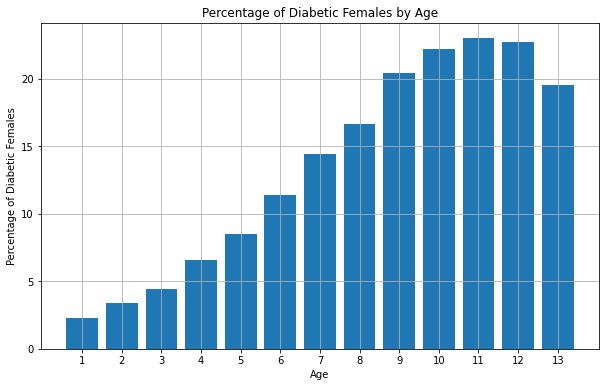

Maximum percentage of diabetic females is 23.00% at age 11.


In [27]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Filter the data for females (assuming 'Sex' column where 0 = female)
data_female = df.filter(df['Sex'] == 0)

# Group by Age and calculate the average diabetes percentage
female_diabetic_by_age = data_female.groupBy('Age').agg(
    (F.avg(df['Diabetes_012']) * 100).alias('DiabetesPercentage')  # Average diabetes rate in percentage
)

# Collect the data to a Pandas DataFrame for plotting
female_diabetic_by_age_pd = female_diabetic_by_age.toPandas()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(female_diabetic_by_age_pd['Age'], female_diabetic_by_age_pd['DiabetesPercentage'])
plt.xlabel('Age')
plt.ylabel('Percentage of Diabetic Females')
plt.title('Percentage of Diabetic Females by Age')
plt.xticks(female_diabetic_by_age_pd['Age'])
plt.grid(True)
plt.show()

# Finding the age with the maximum percentage of diabetic females
max_percent_age = female_diabetic_by_age_pd.loc[female_diabetic_by_age_pd['DiabetesPercentage'].idxmax()]
print("Maximum percentage of diabetic females is {:.2f}% at age {}.".format(max_percent_age['DiabetesPercentage'], int(max_percent_age['Age'])))


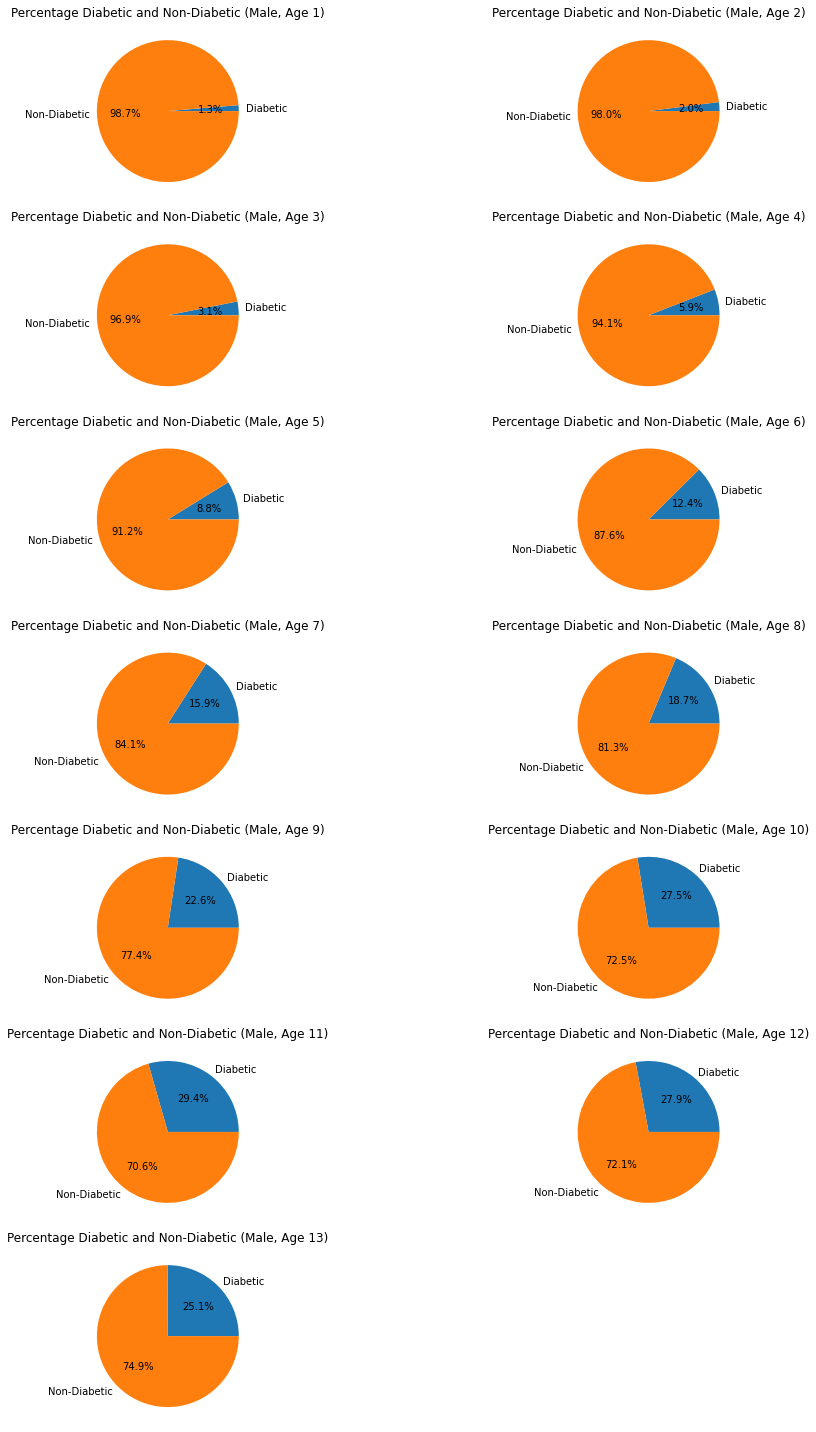

In [29]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Loop over the age range and plot the pie charts for each age
plt.figure(figsize=(15, 20))

for age in range(1, 14):
    # Filter for males (Sex = 1) and the specific age group
    df_male_age = df.filter((df['Sex'] == 1) & (df['Age'] == age))
    
    # Count the total, diabetic and non-diabetic males
    total_male = df_male_age.count()
    diabetic_male = df_male_age.filter(df_male_age['Diabetes_012'] == 1).count()
    non_diabetic_male = df_male_age.filter(df_male_age['Diabetes_012'] == 0).count()

    # Plot the pie chart for each age group
    plt.subplot(7, 2, age)
    plt.pie([diabetic_male, non_diabetic_male], labels=['Diabetic', 'Non-Diabetic'], autopct='%1.1f%%')
    plt.title(f'Percentage Diabetic and Non-Diabetic (Male, Age {age})')

plt.tight_layout()
plt.show()


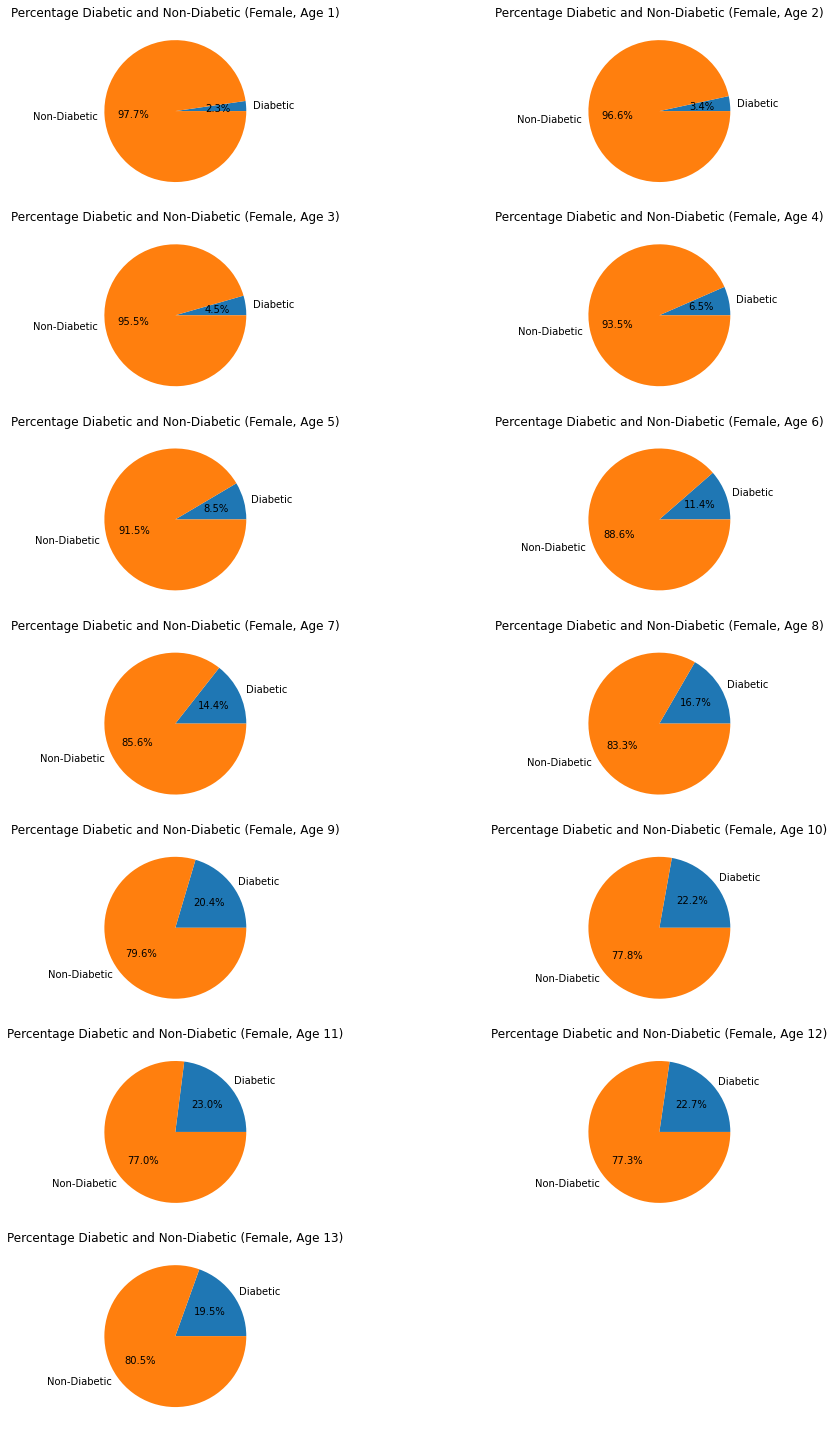

In [30]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Loop over the age range and plot the pie charts for each age
plt.figure(figsize=(15, 20))

for age in range(1, 14):
    # Filter for females (Sex = 0) and the specific age group
    df_female_age = df.filter((df['Sex'] == 0) & (df['Age'] == age))
    
    # Count the total, diabetic and non-diabetic females
    total_female = df_female_age.count()
    diabetic_female = df_female_age.filter(df_female_age['Diabetes_012'] == 1).count()
    non_diabetic_female = df_female_age.filter(df_female_age['Diabetes_012'] == 0).count()

    # Plot the pie chart for each age group
    plt.subplot(7, 2, age)
    plt.pie([diabetic_female, non_diabetic_female], labels=['Diabetic', 'Non-Diabetic'], autopct='%1.1f%%')
    plt.title(f'Percentage Diabetic and Non-Diabetic (Female, Age {age})')

plt.tight_layout()
plt.show()


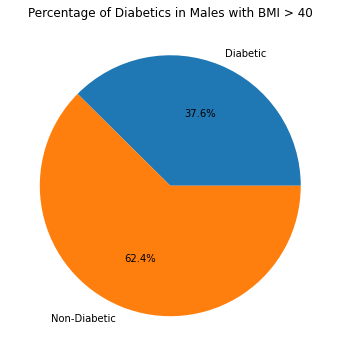

Percentage of diabetics in males with BMI > 40: 37.6%


In [31]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Filter data for males with BMI > 40
male_high_bmi = df.filter((df['Sex'] == 1) & (df['BMI'] > 40))

# Count the total males with high BMI and the diabetic males
total_male_high_bmi = male_high_bmi.count()
diabetic_male_high_bmi = male_high_bmi.filter(male_high_bmi['Diabetes_012'] == 1).count()

# Calculate the percentage of diabetics
percent_diabetic = (diabetic_male_high_bmi / total_male_high_bmi) * 100

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie([percent_diabetic, 100 - percent_diabetic], labels=['Diabetic', 'Non-Diabetic'], autopct='%1.1f%%')
plt.title('Percentage of Diabetics in Males with BMI > 40')
plt.show()

# Print the percentage of diabetics
print(f"Percentage of diabetics in males with BMI > 40: {percent_diabetic:.1f}%")


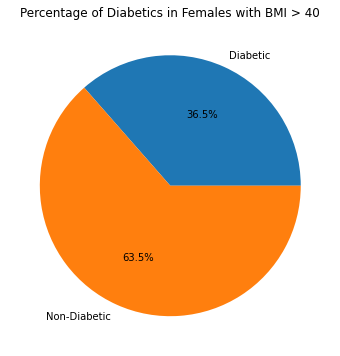

Percentage of diabetics in females with BMI > 40: 36.5%


In [33]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Filter data for females with BMI > 40
female_high_bmi = df.filter((df['Sex'] == 0) & (df['BMI'] > 40))

# Count the total females with high BMI and the diabetic females
total_female_high_bmi = female_high_bmi.count()
diabetic_female_high_bmi = female_high_bmi.filter(female_high_bmi['Diabetes_012'] == 1).count()

# Calculate the percentage of diabetics
percent_diabetic = (diabetic_female_high_bmi / total_female_high_bmi) * 100

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie([percent_diabetic, 100 - percent_diabetic], labels=['Diabetic', 'Non-Diabetic'], autopct='%1.1f%%')
plt.title('Percentage of Diabetics in Females with BMI > 40')
plt.show()

# Print the percentage of diabetics
print(f"Percentage of diabetics in females with BMI > 40: {percent_diabetic:.1f}%")


In [34]:
# Group data by Sex and DiffWalk, calculate mean Diabetes

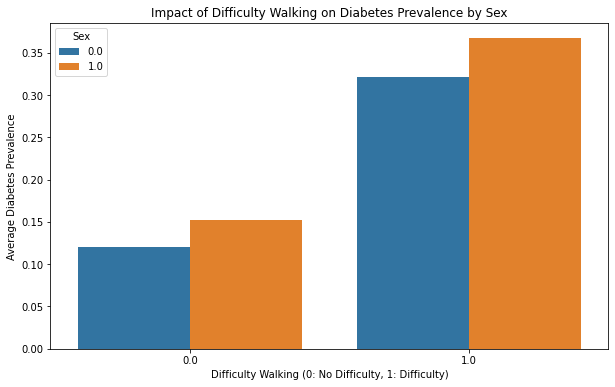

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Group data by Sex and DiffWalk, calculate mean Diabetes prevalence
grouped_data = df.groupBy('Sex', 'DiffWalk').agg(F.avg('Diabetes_012').alias('Diabetes'))

# Convert to Pandas DataFrame for plotting
grouped_data_pd = grouped_data.toPandas()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='DiffWalk', y='Diabetes', hue='Sex', data=grouped_data_pd)
plt.xlabel('Difficulty Walking (0: No Difficulty, 1: Difficulty)')
plt.ylabel('Average Diabetes Prevalence')
plt.title('Impact of Difficulty Walking on Diabetes Prevalence by Sex')
plt.show()


In [36]:
# # the percent impact of income  in  diabetic for male and female

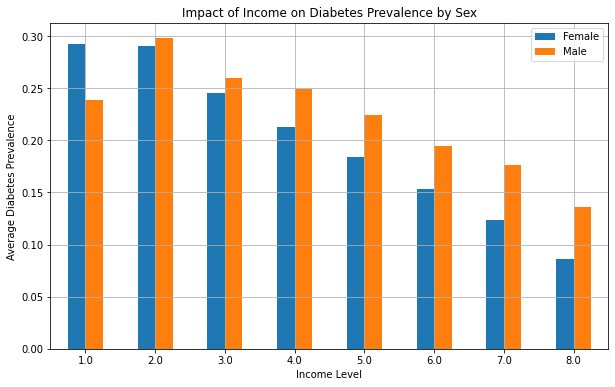

In [37]:
import matplotlib.pyplot as plt

# Group data by Income and Sex, calculate mean Diabetes prevalence
income_diabetes_by_sex = df.groupBy('Income', 'Sex').agg(F.avg('Diabetes_012').alias('Diabetes'))

# Convert to Pandas DataFrame for plotting
income_diabetes_by_sex_pd = income_diabetes_by_sex.toPandas().pivot(index='Income', columns='Sex', values='Diabetes')

# Plot the bar chart
income_diabetes_by_sex_pd.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Income Level')
plt.ylabel('Average Diabetes Prevalence')
plt.title('Impact of Income on Diabetes Prevalence by Sex')
plt.xticks(rotation=0)
plt.legend(['Female', 'Male'])
plt.grid(True)
plt.show()


In [38]:
# # the percent impact of education  in  diabetic for male and female

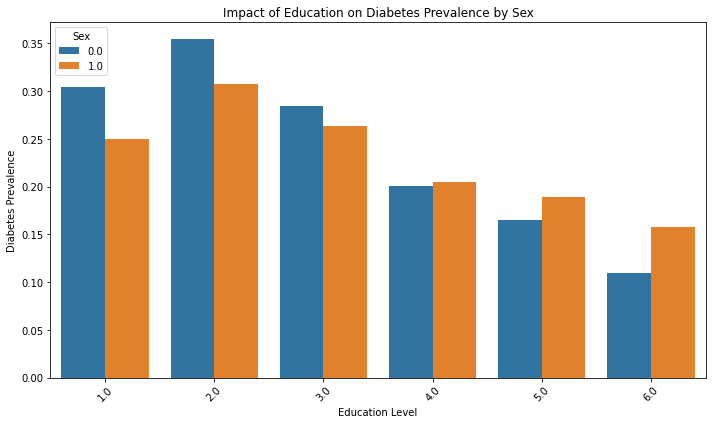

In [39]:

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Group data by Education and Sex, calculate mean Diabetes prevalence
education_diabetes = df.groupBy('Education', 'Sex').agg(F.avg('Diabetes_012').alias('Diabetes'))

# Convert to Pandas DataFrame for plotting
education_diabetes_pd = education_diabetes.toPandas()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Education', y='Diabetes', hue='Sex', data=education_diabetes_pd)
plt.xlabel('Education Level')
plt.ylabel('Diabetes Prevalence')
plt.title('Impact of Education on Diabetes Prevalence by Sex')
plt.xticks(rotation=45)
plt.legend(title='Sex', loc='upper left')
plt.tight_layout()
plt.show()


In [40]:
# the percent impact of genhlth  in  diabetic for male and female
# Group data by gender and general health, then calculate mean diabetes prevalence

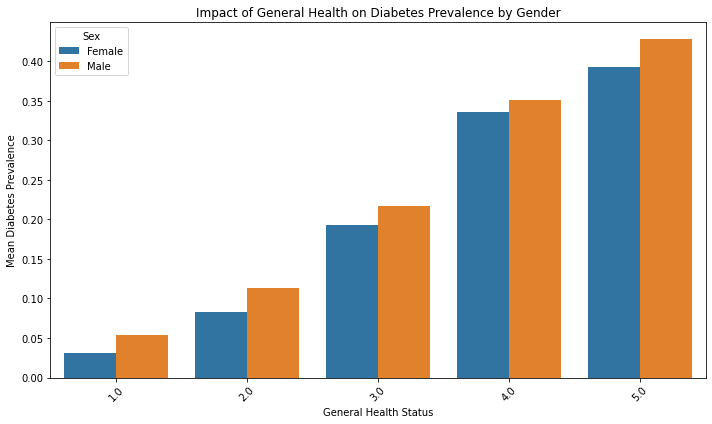

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Group data by Sex and GenHlth, calculate mean Diabetes prevalence
grouped_data = df.groupBy('Sex', 'GenHlth').agg(F.avg('Diabetes_012').alias('Diabetes'))

# Map sex values to labels
grouped_data = grouped_data.withColumn('Sex', F.when(F.col('Sex') == 0, 'Female')
                                      .otherwise('Male'))

# Convert to Pandas DataFrame for plotting
grouped_data_pd = grouped_data.toPandas()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='GenHlth', y='Diabetes', hue='Sex', data=grouped_data_pd)
plt.xlabel('General Health Status')
plt.ylabel('Mean Diabetes Prevalence')
plt.title('Impact of General Health on Diabetes Prevalence by Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
# the percent impact of PhysActivity  in  diabetic for male and female

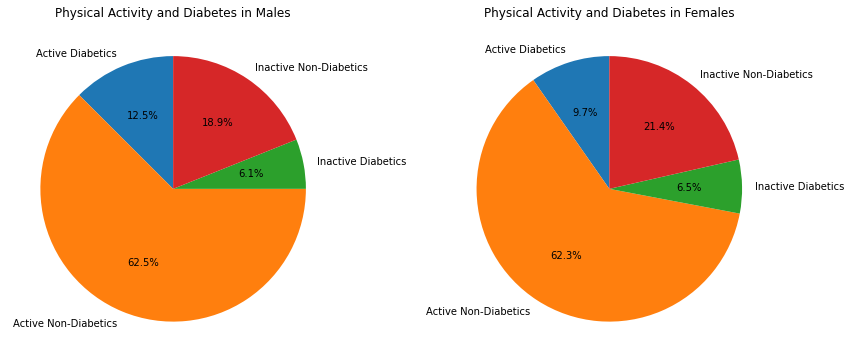

In [44]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Filter data for males and females
male_data = df.filter(df['Sex'] == 1)
female_data = df.filter(df['Sex'] == 0)

# Calculate counts for males based on PhysActivity and Diabetes
male_active_diabetics = male_data.filter((male_data['PhysActivity'] == 1) & (male_data['Diabetes_012'] == 1)).count()
male_active_non_diabetics = male_data.filter((male_data['PhysActivity'] == 1) & (male_data['Diabetes_012'] == 0)).count()
male_inactive_diabetics = male_data.filter((male_data['PhysActivity'] == 0) & (male_data['Diabetes_012'] == 1)).count()
male_inactive_non_diabetics = male_data.filter((male_data['PhysActivity'] == 0) & (male_data['Diabetes_012'] == 0)).count()

# Calculate counts for females based on PhysActivity and Diabetes
female_active_diabetics = female_data.filter((female_data['PhysActivity'] == 1) & (female_data['Diabetes_012'] == 1)).count()
female_active_non_diabetics = female_data.filter((female_data['PhysActivity'] == 1) & (female_data['Diabetes_012'] == 0)).count()
female_inactive_diabetics = female_data.filter((female_data['PhysActivity'] == 0) & (female_data['Diabetes_012'] == 1)).count()
female_inactive_non_diabetics = female_data.filter((female_data['PhysActivity'] == 0) & (female_data['Diabetes_012'] == 0)).count()

# Create pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Male pie chart
axes[0].pie([male_active_diabetics, male_active_non_diabetics, male_inactive_diabetics, male_inactive_non_diabetics],
            labels=['Active Diabetics', 'Active Non-Diabetics', 'Inactive Diabetics', 'Inactive Non-Diabetics'],
            autopct='%1.1f%%', startangle=90)
axes[0].set_title('Physical Activity and Diabetes in Males')

# Female pie chart
axes[1].pie([female_active_diabetics, female_active_non_diabetics, female_inactive_diabetics, female_inactive_non_diabetics],
            labels=['Active Diabetics', 'Active Non-Diabetics', 'Inactive Diabetics', 'Inactive Non-Diabetics'],
            autopct='%1.1f%%', startangle=90)
axes[1].set_title('Physical Activity and Diabetes in Females')

plt.tight_layout()
plt.show()


In [45]:
#the frequency impact of   physicalhlth  in diabetic for male and female

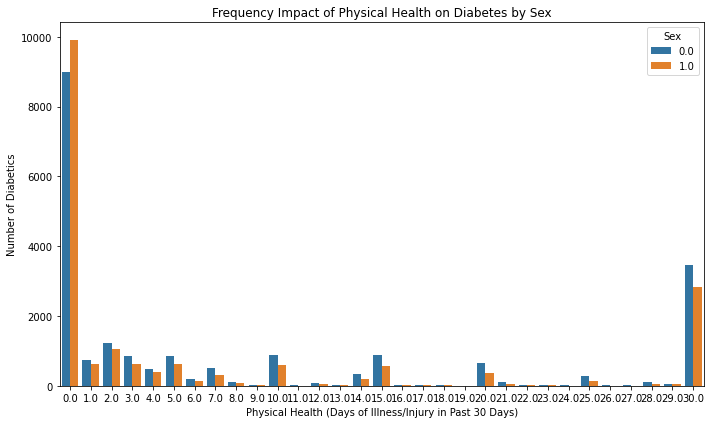

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Group data by Sex and PhysHlth, then calculate the sum of Diabetics (1 for diabetic)
diabetic_by_sex_physhlth = df.groupBy('Sex', 'PhysHlth').agg(F.sum('Diabetes_012').alias('Diabetic_Count')).toPandas()

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='PhysHlth', y='Diabetic_Count', hue='Sex', data=diabetic_by_sex_physhlth)
plt.xlabel('Physical Health (Days of Illness/Injury in Past 30 Days)')
plt.ylabel('Number of Diabetics')
plt.title('Frequency Impact of Physical Health on Diabetes by Sex')
plt.tight_layout()
plt.show()


In [47]:
#the percent impact of   HeartDiseaseorAttack in diabetic for male and female


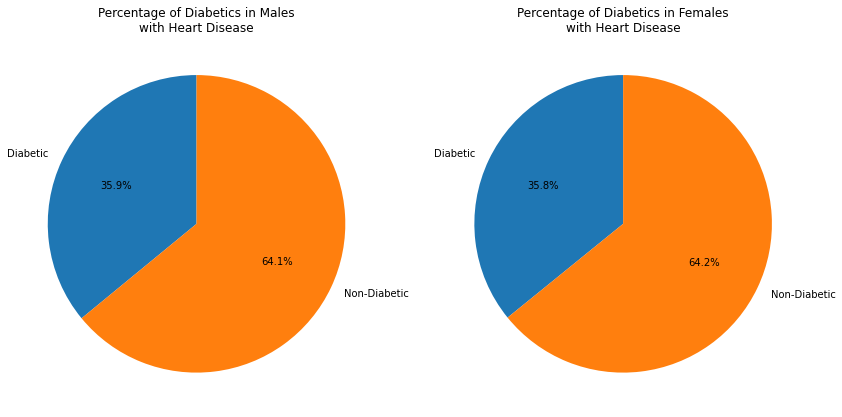

Percentage of diabetics in males with heart disease: 35.9%
Percentage of diabetics in males without heart disease: 15.9%
Percentage of diabetics in females with heart disease: 35.8%
Percentage of diabetics in females without heart disease: 14.6%


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Filter data for males and females with and without heart disease
male_data = df.filter((df['Sex'] == 1) & (df['HeartDiseaseorAttack'] == 1))
male_nohd_data = df.filter((df['Sex'] == 1) & (df['HeartDiseaseorAttack'] == 0))
female_data = df.filter((df['Sex'] == 0) & (df['HeartDiseaseorAttack'] == 1))
female_nohd_data = df.filter((df['Sex'] == 0) & (df['HeartDiseaseorAttack'] == 0))

# Calculate percentage of diabetics for each group
male_hd_diabetic_percent = (male_data.filter(df['Diabetes_012'] == 1).count() / male_data.count()) * 100
male_nohd_diabetic_percent = (male_nohd_data.filter(df['Diabetes_012'] == 1).count() / male_nohd_data.count()) * 100
female_hd_diabetic_percent = (female_data.filter(df['Diabetes_012'] == 1).count() / female_data.count()) * 100
female_nohd_diabetic_percent = (female_nohd_data.filter(df['Diabetes_012'] == 1).count() / female_nohd_data.count()) * 100

# Create pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Male pie chart with heart disease
axes[0].pie([male_hd_diabetic_percent, 100 - male_hd_diabetic_percent], 
            labels=['Diabetic', 'Non-Diabetic'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Percentage of Diabetics in Males\nwith Heart Disease')

# Female pie chart with heart disease
axes[1].pie([female_hd_diabetic_percent, 100 - female_hd_diabetic_percent], 
            labels=['Diabetic', 'Non-Diabetic'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Percentage of Diabetics in Females\nwith Heart Disease')

plt.tight_layout()
plt.show()

# Output the calculated percentages
print(f"Percentage of diabetics in males with heart disease: {male_hd_diabetic_percent:.1f}%")
print(f"Percentage of diabetics in males without heart disease: {male_nohd_diabetic_percent:.1f}%")
print(f"Percentage of diabetics in females with heart disease: {female_hd_diabetic_percent:.1f}%")
print(f"Percentage of diabetics in females without heart disease: {female_nohd_diabetic_percent:.1f}%")


In [49]:
# the percent impact of Stroke  in diabetic for male and female

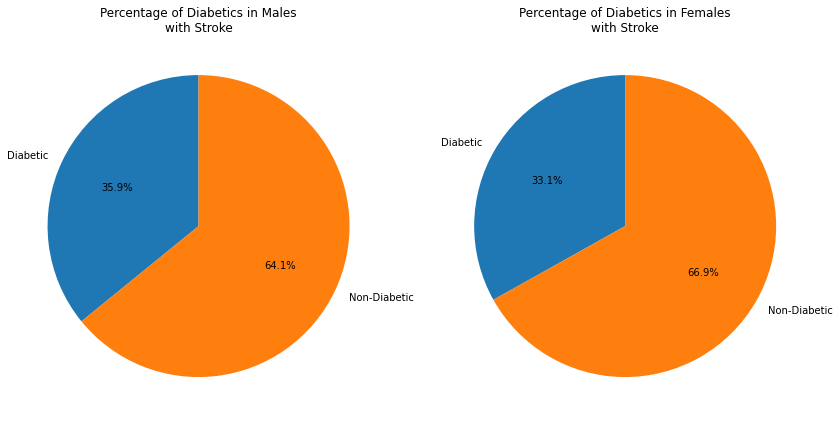

Percentage of diabetics in males with stroke: 35.9%
Percentage of diabetics in females with stroke: 33.1%


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Filter data for males and females with stroke
male_stroke_data = df.filter((df['Sex'] == 1) & (df['Stroke'] == 1))
female_stroke_data = df.filter((df['Sex'] == 0) & (df['Stroke'] == 1))

# Calculate percentage of diabetics for males with stroke
total_male_stroke = male_stroke_data.count()
diabetic_male_stroke = male_stroke_data.filter(df['Diabetes_012'] == 1).count()
percent_diabetic_male_stroke = (diabetic_male_stroke / total_male_stroke) * 100

# Calculate percentage of diabetics for females with stroke
total_female_stroke = female_stroke_data.count()
diabetic_female_stroke = female_stroke_data.filter(df['Diabetes_012'] == 1).count()
percent_diabetic_female_stroke = (diabetic_female_stroke / total_female_stroke) * 100

# Create pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Male pie chart with stroke
axes[0].pie([percent_diabetic_male_stroke, 100 - percent_diabetic_male_stroke],
            labels=['Diabetic', 'Non-Diabetic'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Percentage of Diabetics in Males\nwith Stroke')

# Female pie chart with stroke
axes[1].pie([percent_diabetic_female_stroke, 100 - percent_diabetic_female_stroke],
            labels=['Diabetic', 'Non-Diabetic'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Percentage of Diabetics in Females\nwith Stroke')

plt.tight_layout()
plt.show()

# Output the calculated percentages
print(f"Percentage of diabetics in males with stroke: {percent_diabetic_male_stroke:.1f}%")
print(f"Percentage of diabetics in females with stroke: {percent_diabetic_female_stroke:.1f}%")


In [51]:
#the percent impact of HighBP  in  diabetic for male and female

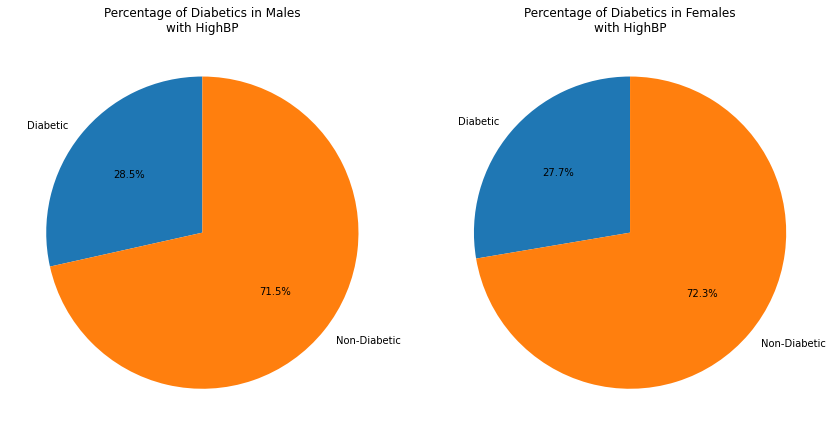

Percentage of diabetics in males with HighBP: 28.5%
Percentage of diabetics in females with HighBP: 27.7%


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# Filter data for males and females with HighBP
male_highbp_data = df.filter((df['Sex'] == 1) & (df['HighBP'] == 1))
female_highbp_data = df.filter((df['Sex'] == 0) & (df['HighBP'] == 1))

# Calculate percentage of diabetics for males with HighBP
total_male_highbp = male_highbp_data.count()
diabetic_male_highbp = male_highbp_data.filter(df['Diabetes_012'] == 1).count()
male_percent_diabetic = (diabetic_male_highbp / total_male_highbp) * 100

# Calculate percentage of diabetics for females with HighBP
total_female_highbp = female_highbp_data.count()
diabetic_female_highbp = female_highbp_data.filter(df['Diabetes_012'] == 1).count()
female_percent_diabetic = (diabetic_female_highbp / total_female_highbp) * 100

# Create pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Male pie chart with HighBP
axes[0].pie([male_percent_diabetic, 100 - male_percent_diabetic],
            labels=['Diabetic', 'Non-Diabetic'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Percentage of Diabetics in Males\nwith HighBP')

# Female pie chart with HighBP
axes[1].pie([female_percent_diabetic, 100 - female_percent_diabetic],
            labels=['Diabetic', 'Non-Diabetic'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Percentage of Diabetics in Females\nwith HighBP')

plt.tight_layout()
plt.show()

# Output the calculated percentages
print(f"Percentage of diabetics in males with HighBP: {male_percent_diabetic:.1f}%")
print(f"Percentage of diabetics in females with HighBP: {female_percent_diabetic:.1f}%")


In [53]:
# Filter data for males and females with and without HighChol

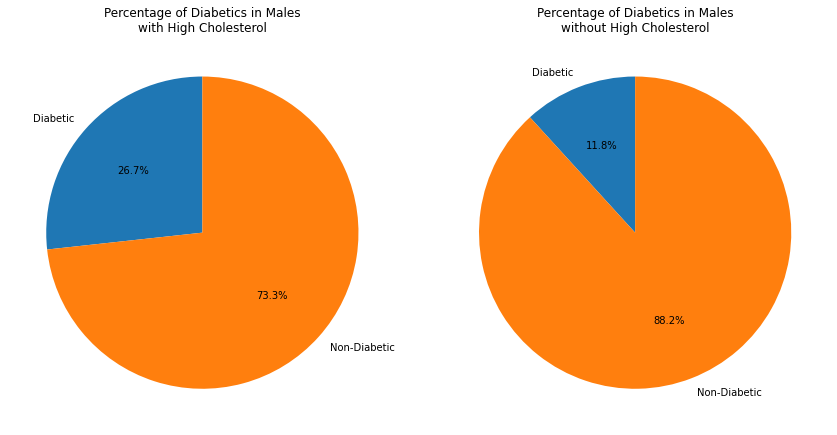

Percentage of diabetics in males with High Cholesterol: 26.7%
Percentage of diabetics in males without High Cholesterol: 11.8%
Percentage of diabetics in females with High Cholesterol: 25.3%
Percentage of diabetics in females without High Cholesterol: 9.4%


In [54]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Filter data for males and females with and without High Cholesterol
male_highchol_data = df.filter((df['Sex'] == 1) & (df['HighChol'] == 1))
male_no_highchol_data = df.filter((df['Sex'] == 1) & (df['HighChol'] == 0))
female_highchol_data = df.filter((df['Sex'] == 0) & (df['HighChol'] == 1))
female_no_highchol_data = df.filter((df['Sex'] == 0) & (df['HighChol'] == 0))

# Calculate percentages of diabetics for males with High Cholesterol
total_male_highchol = male_highchol_data.count()
diabetic_male_highchol = male_highchol_data.filter(df['Diabetes_012'] == 1).count()
male_highchol_diabetic_percent = (diabetic_male_highchol / total_male_highchol) * 100

# Calculate percentages of diabetics for males without High Cholesterol
total_male_no_highchol = male_no_highchol_data.count()
diabetic_male_no_highchol = male_no_highchol_data.filter(df['Diabetes_012'] == 1).count()
male_no_highchol_diabetic_percent = (diabetic_male_no_highchol / total_male_no_highchol) * 100

# Calculate percentages of diabetics for females with High Cholesterol
total_female_highchol = female_highchol_data.count()
diabetic_female_highchol = female_highchol_data.filter(df['Diabetes_012'] == 1).count()
female_highchol_diabetic_percent = (diabetic_female_highchol / total_female_highchol) * 100

# Calculate percentages of diabetics for females without High Cholesterol
total_female_no_highchol = female_no_highchol_data.count()
diabetic_female_no_highchol = female_no_highchol_data.filter(df['Diabetes_012'] == 1).count()
female_no_highchol_diabetic_percent = (diabetic_female_no_highchol / total_female_no_highchol) * 100

# Create pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Male pie chart for High Cholesterol
axes[0].pie([male_highchol_diabetic_percent, 100 - male_highchol_diabetic_percent],
            labels=['Diabetic', 'Non-Diabetic'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Percentage of Diabetics in Males\nwith High Cholesterol')

# Male pie chart for No High Cholesterol
axes[1].pie([male_no_highchol_diabetic_percent, 100 - male_no_highchol_diabetic_percent],
            labels=['Diabetic', 'Non-Diabetic'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Percentage of Diabetics in Males\nwithout High Cholesterol')

plt.tight_layout()
plt.show()

# Output the calculated percentages
print(f"Percentage of diabetics in males with High Cholesterol: {male_highchol_diabetic_percent:.1f}%")
print(f"Percentage of diabetics in males without High Cholesterol: {male_no_highchol_diabetic_percent:.1f}%")
print(f"Percentage of diabetics in females with High Cholesterol: {female_highchol_diabetic_percent:.1f}%")
print(f"Percentage of diabetics in females without High Cholesterol: {female_no_highchol_diabetic_percent:.1f}%")


In [55]:
# the percent impact of smoke in diabetic

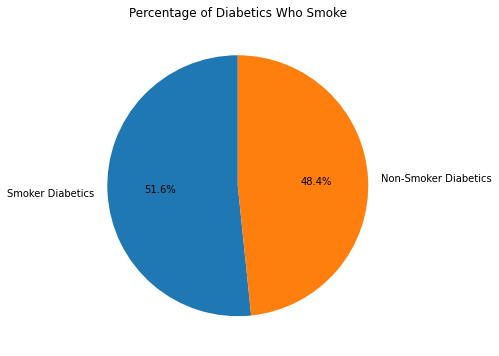

Smoker Diabetics: 20478
Non-Smoker Diabetics: 19179


In [56]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Filter data for diabetics who smoke and non-smokers who are diabetic
smoker_diabetics = df.filter((df['Diabetes_012'] == 1) & (df['Smoker'] == 1)).count()
non_smoker_diabetics = df.filter((df['Diabetes_012'] == 1) & (df['Smoker'] == 0)).count()

# Labels and sizes for the pie chart
labels = ['Smoker Diabetics', 'Non-Smoker Diabetics']
sizes = [smoker_diabetics, non_smoker_diabetics]

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Diabetics Who Smoke')
plt.show()

# Print the result
print(f"Smoker Diabetics: {smoker_diabetics}")
print(f"Non-Smoker Diabetics: {non_smoker_diabetics}")


In [57]:
# Count diabetic and non-diabetic males and females

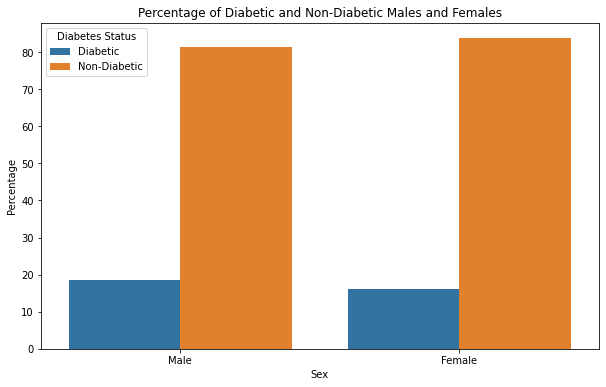

In [58]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for males and females with diabetes status
male_diabetic = df.filter((df['Sex'] == 1) & (df['Diabetes_012'] == 1)).count()
male_non_diabetic = df.filter((df['Sex'] == 1) & (df['Diabetes_012'] == 0)).count()
female_diabetic = df.filter((df['Sex'] == 0) & (df['Diabetes_012'] == 1)).count()
female_non_diabetic = df.filter((df['Sex'] == 0) & (df['Diabetes_012'] == 0)).count()

# Create a DataFrame for plotting
data = [
    ('Male', 'Diabetic', male_diabetic),
    ('Male', 'Non-Diabetic', male_non_diabetic),
    ('Female', 'Diabetic', female_diabetic),
    ('Female', 'Non-Diabetic', female_non_diabetic)
]

columns = ['Sex', 'Diabetes Status', 'Count']
plot_df = spark.createDataFrame(data, columns)

# Calculate total count per sex
total_male = plot_df.filter(plot_df['Sex'] == 'Male').agg(F.sum('Count')).collect()[0][0]
total_female = plot_df.filter(plot_df['Sex'] == 'Female').agg(F.sum('Count')).collect()[0][0]

# Calculate percentage
plot_df = plot_df.withColumn('Percentage', 
                             (plot_df['Count'] / F.when(plot_df['Sex'] == 'Male', total_male).otherwise(total_female)) * 100)

# Collect data into pandas DataFrame for plotting
pandas_df = plot_df.toPandas()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Sex', y='Percentage', hue='Diabetes Status', data=pandas_df)
plt.xlabel('Sex')
plt.ylabel('Percentage')
plt.title('Percentage of Diabetic and Non-Diabetic Males and Females')
plt.show()


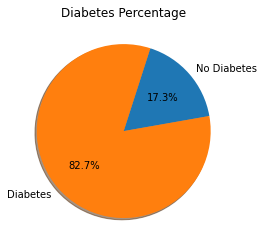

In [59]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Get value counts for the Diabetes column
diabetes_counts = df.groupBy('Diabetes_012').count().collect()

# Prepare the data for plotting
labels = ['No Diabetes', 'Diabetes']
counts = [row['count'] for row in diabetes_counts]

# Create a pie chart
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%', shadow=True, startangle=10)
ax.set_title('Diabetes Percentage')
plt.show()


In [62]:
# if two features grouped how they will impact on diabetes for male and female

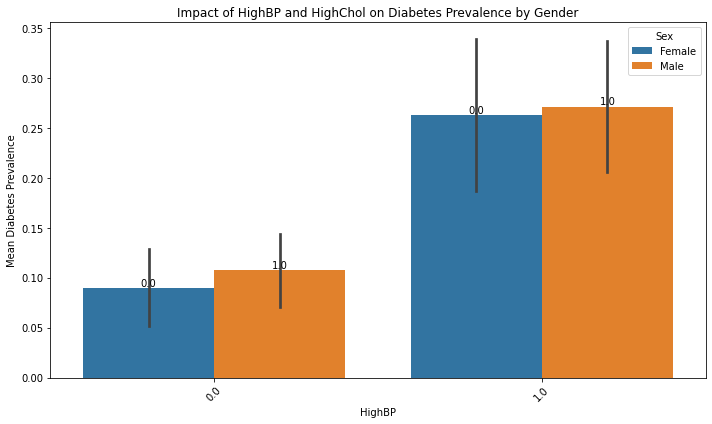

In [64]:
from pyspark.sql.functions import avg

# Group data by 'Sex', 'HighBP', and 'HighChol' and calculate the mean of 'Diabetes'
grouped_data = df.groupBy('Sex', 'HighBP', 'HighChol').agg(avg('Diabetes_012').alias('Mean_Diabetes'))

# Convert Spark DataFrame to Pandas DataFrame for plotting
pandas_data = grouped_data.toPandas()

# Map 'Sex' values to labels
pandas_data['Sex'] = pandas_data['Sex'].map({0: 'Female', 1: 'Male'})

# Plot using seaborn (make sure to import the required libraries)
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='HighBP', y='Mean_Diabetes', hue='Sex', data=pandas_data)
plt.xlabel('HighBP')
plt.ylabel('Mean Diabetes Prevalence')
plt.title('Impact of HighBP and HighChol on Diabetes Prevalence by Gender')

# Add annotations for 'HighChol' values
for i, bar in enumerate(plt.gca().patches):
    height = bar.get_height()
    group_idx = i // len(pandas_data['HighBP'].unique())
    highchol_value = pandas_data['HighChol'].unique()[group_idx % len(pandas_data['HighChol'].unique())]
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(highchol_value), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

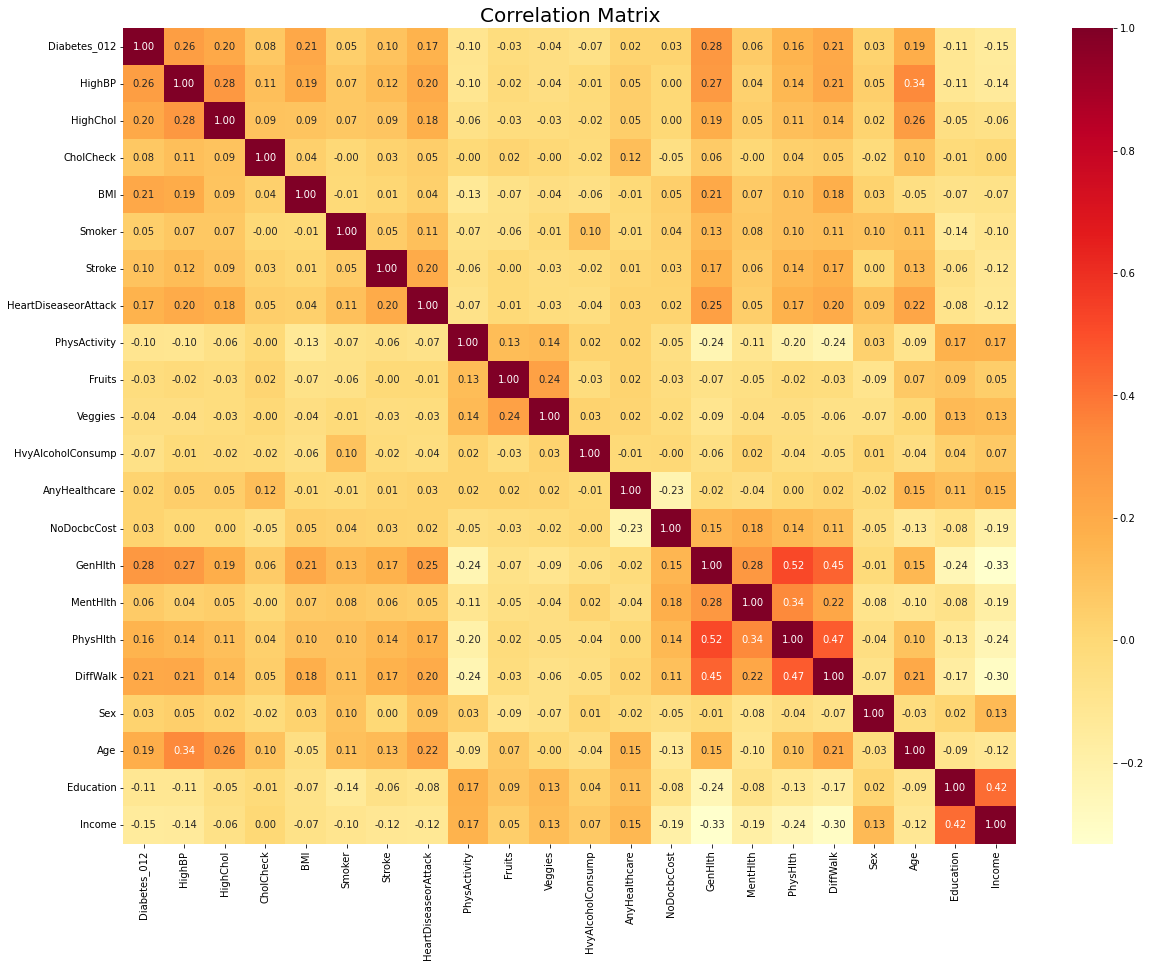

In [70]:
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get numeric columns from the PySpark DataFrame
numeric_columns = [col_name for col_name, dtype in df.dtypes if dtype in ['int', 'double']]

# Initialize an empty dictionary to store correlations
correlations_dict = {}

# Compute correlations between numeric columns using PySpark's stat.corr
for col1 in numeric_columns:
    correlations_dict[col1] = {}
    for col2 in numeric_columns:
        correlation_value = df.stat.corr(col1, col2)  # Calculate correlation
        correlations_dict[col1][col2] = correlation_value

# Convert the dictionary to a Pandas DataFrame
correlations = pd.DataFrame(correlations_dict)

# Plot the correlation matrix heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlations, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title("Correlation Matrix", fontsize=20)
plt.show()


In [75]:
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 22.2 MB 3.0 MB/s            
     |████████████████████████████████| 309 kB 2.1 MB/s            


In [81]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.ml.stat import ChiSquareTest
from pyspark.ml.feature import VectorAssembler

# Initialize Spark session
spark = SparkSession.builder.appName("ChiSquareTest").getOrCreate()

# Convert Pandas DataFrame to PySpark DataFrame (if needed)
if isinstance(df, pd.DataFrame):  # If df is a Pandas DataFrame, convert it
    df = spark.createDataFrame(df)

# Ensure all columns (except target) are numeric
for col_name, dtype in df.dtypes:
    if dtype not in ['int', 'double']:  # Convert non-numeric columns
        df = df.withColumn(col_name, df[col_name].cast(DoubleType()))

# Assemble features
assembler = VectorAssembler(inputCols=[col for col in df.columns if col != 'Diabetes_012'], outputCol='features')
assembled_df = assembler.transform(df)

# Run Chi-Square test
chi_square_test = ChiSquareTest.test(assembled_df, 'features', 'Diabetes_012')

# Collect the results properly
chi_square_results = chi_square_test.collect()[0]  # Extract first row

# Extract values from the row
p_values = chi_square_results['pValues']  # List of p-values for each feature
statistics = chi_square_results['statistics']  # List of chi-square statistics for each feature
degrees_of_freedom = chi_square_results['degreesOfFreedom']  # Degrees of freedom for each feature

# Print the results
print("Chi-Square Statistics:", statistics)
print("P-Values:", p_values)
print("Degrees of Freedom:", degrees_of_freedom)



Chi-Square Statistics: [15563.784150157668,9589.763214236656,1330.669148559429,12806.698022603108,494.97924374709544,2199.7080964926454,6431.989322849667,2428.7198395053224,146.5368864274969,437.8561244533879,1000.3792201666315,128.1147444800284,157.31552243211664,18940.007001311325,1257.3591307630695,6282.383695159729,9993.185506751426,212.6755764988547,8844.88101438807,2856.079774713934,5152.975288107819]
P-Values: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Degrees of Freedom: [1, 1, 1, 83, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 30, 30, 1, 1, 12, 5, 7]


In [82]:
data=df.toPandas()
df=data

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assuming 'df' is the DataFrame and 'Diabetes_012' is the target variable
X = df.drop('Diabetes_012', axis=1)  # Features
y = df['Diabetes_012']  # Target

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Apply RFE with Random Forest
rfe = RFE(estimator=rf, n_features_to_select=10)  # Select top 10 features
rfe.fit(X_train, y_train)

# Get the selected features
selected_features_rfe = X.columns[rfe.support_]
print(f"Selected features using RFE: {selected_features_rfe}")


Selected features using RFE: Index(['HighBP', 'BMI', 'Smoker', 'Fruits', 'GenHlth', 'MentHlth', 'PhysHlth',
       'Age', 'Education', 'Income'],
      dtype='object')


In [83]:
# Train the Random Forest Classifier
rf.fit(X_train, y_train)

# Get feature importance
feature_importances = rf.feature_importances_

# Create a DataFrame for easy visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print("Top features by importance:")
print(importance_df.head(10))  # Change the number based on how many top features you want

Top features by importance:
      Feature  Importance
3         BMI    0.185745
18        Age    0.123454
20     Income    0.099843
15   PhysHlth    0.083695
19  Education    0.069914
13    GenHlth    0.067234
14   MentHlth    0.063848
0      HighBP    0.043418
8      Fruits    0.033543
4      Smoker    0.033163


In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Initialize the Logistic Regression model with L1 regularization
lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

# Fit the model
lasso.fit(X_train, y_train)

# Select features with non-zero coefficients
selected_features_lasso = X.columns[lasso.coef_[0] != 0]
print(f"Selected features using Lasso: {selected_features_lasso}")

Selected features using Lasso: Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')
